# Aligning partially matched coronal sections of adult mouse brain from Xenium and STARmap

In this notebook, we align two single cell resolution spatial transcriptomics datasets of full and hemi coronal sections of the adult mouse brain from approximately the same locations assayed by Xenium and STARmap.

We will use `STalign` to achieve this alignment. We will first load the relevant code libraries.

In [3]:
# import dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

# import STalign from upper directory
# skip next 2 lines if STalign.py in same folder as notebook
import sys
sys.path.append("../../") 
import STalign

# make plots bigger
plt.rcParams["figure.figsize"] = (12,10)

We have already downloaded single cell spatial transcriptomics datasets and placed the files in a folder called `merfish_data` and `xenium_data`.

We can read in the cell information for the first dataset using `pandas` as `pd`.

In [4]:
# Single cell data 1
# read in data
fname = '../../xenium_data/Xenium_V1_FF_Mouse_Brain_MultiSection_1_cells.csv.gz'
df1 = pd.read_csv(fname)
print(df1.head())

   cell_id   x_centroid   y_centroid  transcript_counts  control_probe_counts  \
0        1  1557.532239  2528.022437                327                     0   
1        2  1560.669312  2543.632678                354                     0   
2        3  1570.462885  2530.810461                422                     0   
3        4  1573.927734  2546.454529                250                     0   
4        5  1581.344379  2557.024951                550                     1   

   control_codeword_counts  total_counts   cell_area  nucleus_area  
0                        0           327  240.953750     63.038125  
1                        0           354  211.692500     65.476562  
2                        0           422  186.946875     69.540625  
3                        0           250  239.237812     61.728594  
4                        0           552  438.692969     92.209063  


For alignment with `STalign`, we only need the cell centroid information. So we can pull out this information. We can further visualize the cell centroids to get a sense of the variation in cell density that we will be relying on for our alignment by plotting using `matplotlib.pyplot` as `plt`. 

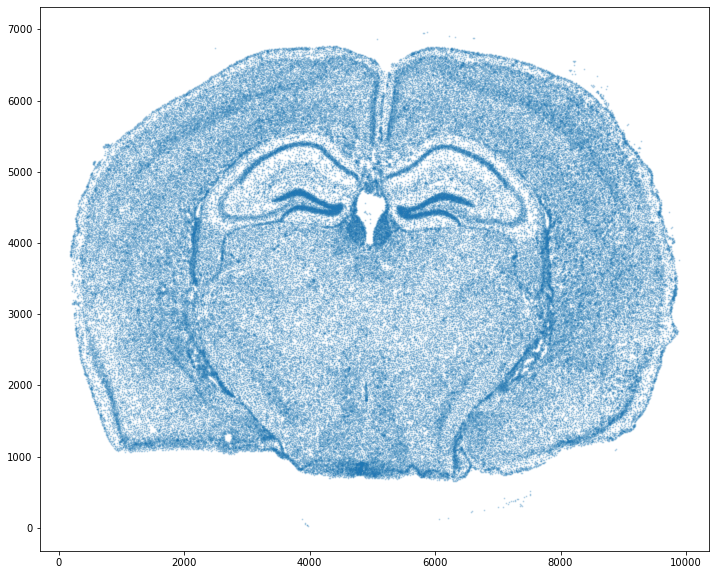

In [5]:
# get cell centroid coordinates
xI = np.array(df1['x_centroid'])
yI = np.array(df1['y_centroid'])

# plot
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.2)

We will first use `STalign` to rasterize the single cell centroid positions into an image. Assuming the single-cell centroid coordinates are in microns, we will perform this rasterization at a 30 micron resolution. We can visualize the resulting rasterized image.

Note that points are plotting with the origin at bottom left while images are typically plotted with origin at top left so we've used `invert_yaxis()` to invert the yaxis for visualization consistency. 

0 of 162033
10000 of 162033
20000 of 162033
30000 of 162033
40000 of 162033
50000 of 162033
60000 of 162033
70000 of 162033
80000 of 162033
90000 of 162033
100000 of 162033
110000 of 162033
120000 of 162033
130000 of 162033
140000 of 162033
150000 of 162033
160000 of 162033
162032 of 162033


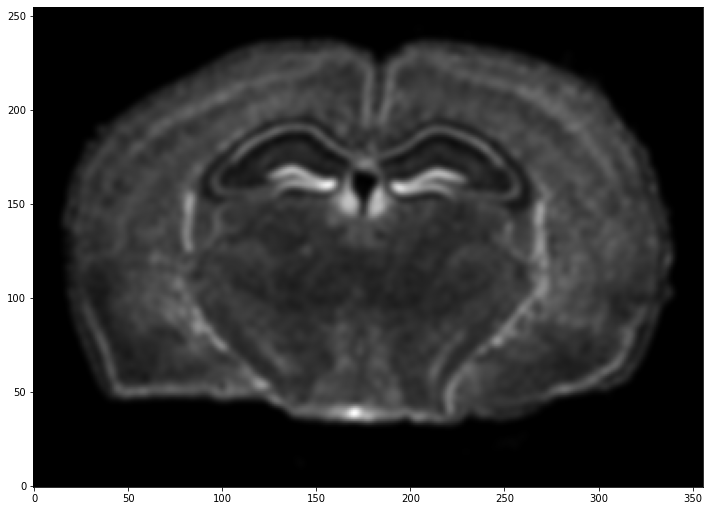

In [9]:
# rasterize at 30um resolution (assuming positions are in um units) and plot
XI,YI,I,fig = STalign.rasterize(xI,yI)

# plot
ax = fig.axes[0]
ax.invert_yaxis()

Now, we can repeat this for the cell information from the second dataset.

In [12]:
# Single cell data 2
# read in data
fname = '../../starmap_data/well11_spatial.csv.gz'
df2 = pd.read_csv(fname, skiprows=[1]) # first row is data type
print(df2.head())

       NAME             X            Y          Z Tissue_Symbol  \
0  well11_0  10834.272727  1488.454545   8.242424      L1_HPFmo   
1  well11_1  12139.406780   864.788136  16.389831      Meninges   
2  well11_2  11848.132075  1225.679245  21.528302      Meninges   
3  well11_3  11090.980392  1342.539216   8.637255      L1_HPFmo   
4  well11_4  11517.905660  1351.735849  15.113208      L1_HPFmo   

                         Maintype_Symbol Subtype_Symbol  
0      Vascular and leptomeningeal cells          VLM_1  
1      Vascular and leptomeningeal cells          VLM_2  
2  Telencephalon inhibitory interneurons        TEINH_9  
3      Vascular and leptomeningeal cells          VLM_1  
4  Telencephalon inhibitory interneurons        TEINH_9  


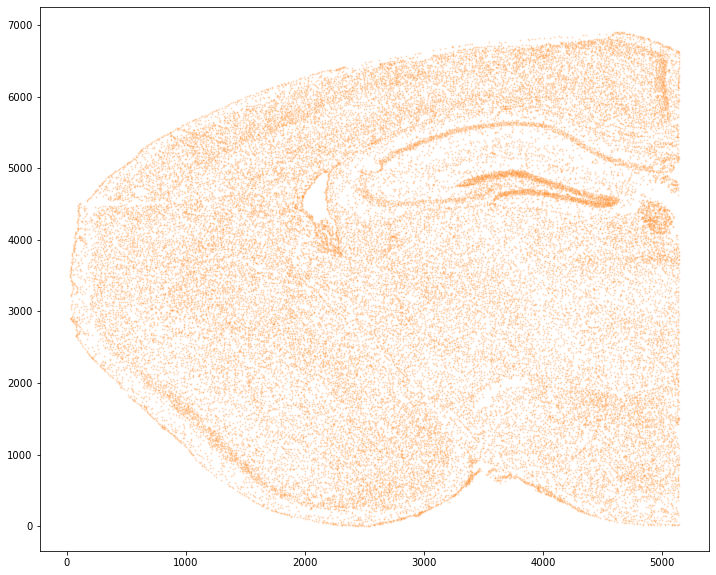

In [17]:
# get cell centroids
xJ = np.array(df2['Y'])/5 # convert to similar scale
yJ = np.array(df2['X'])/5

# flip
yJ = yJ.max() - yJ

# plot
fig,ax = plt.subplots()
ax.scatter(xJ,yJ,s=1,alpha=0.2,c='#ff7f0e')

0 of 43341
10000 of 43341
20000 of 43341
30000 of 43341
40000 of 43341
43340 of 43341


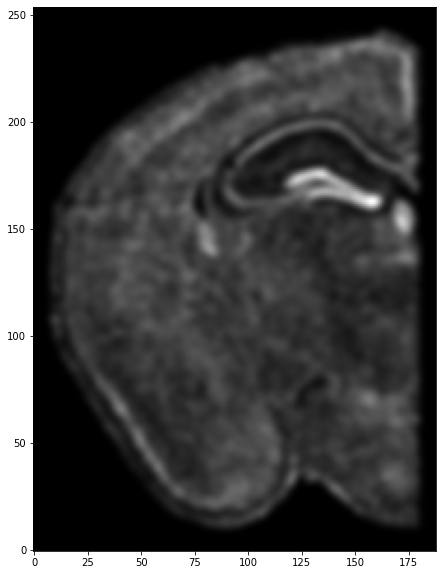

In [18]:
# rasterize and plot
XJ,YJ,J,fig = STalign.rasterize(xJ,yJ)
ax = fig.axes[0]
ax.invert_yaxis()

Note that plotting the cell centroid positions from both datasets shows that non-linear local alignment is needed.

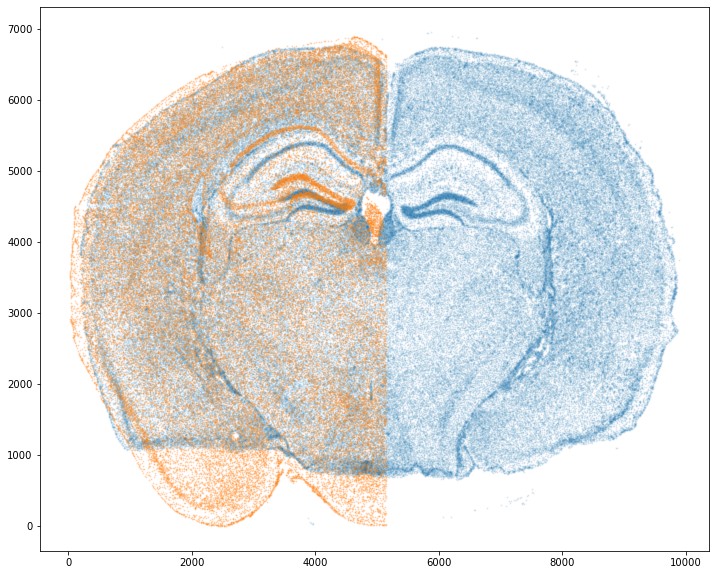

In [21]:
# plot
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.1)
ax.scatter(xJ,yJ,s=1,alpha=0.2)

We can also plot the rasterized images next to each other.

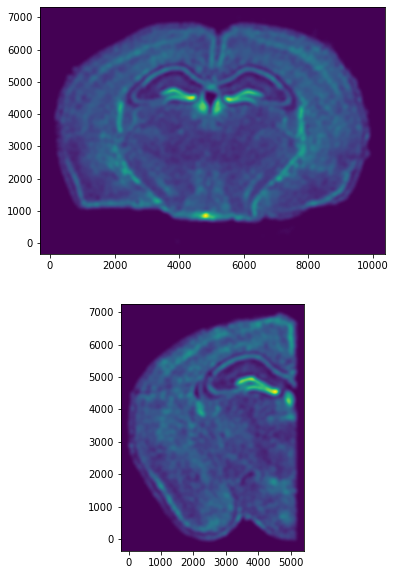

In [22]:
# get extent of images
extentI = STalign.extent_from_x((YI,XI))
extentJ = STalign.extent_from_x((YJ,XJ))

# plot rasterized images
fig,ax = plt.subplots(2,1)
ax[0].imshow((I.transpose(1,2,0).squeeze()), extent=extentI) 
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ) 
ax[0].invert_yaxis()
ax[1].invert_yaxis()

Now we will perform our alignment. There are many parameters that can be tuned for performing this alignment. If we don't specify parameters, defaults will be used. 

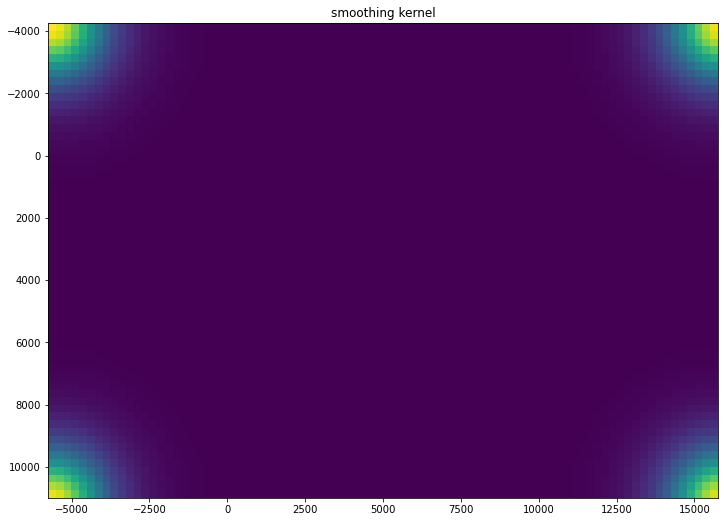

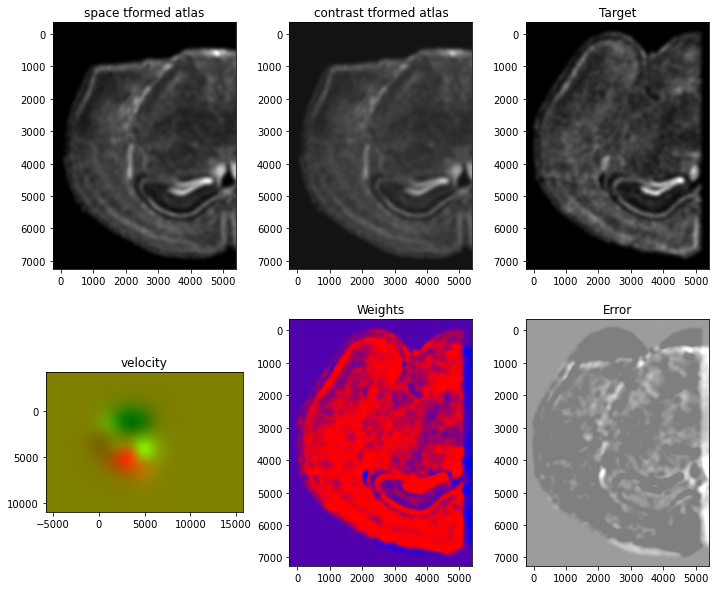

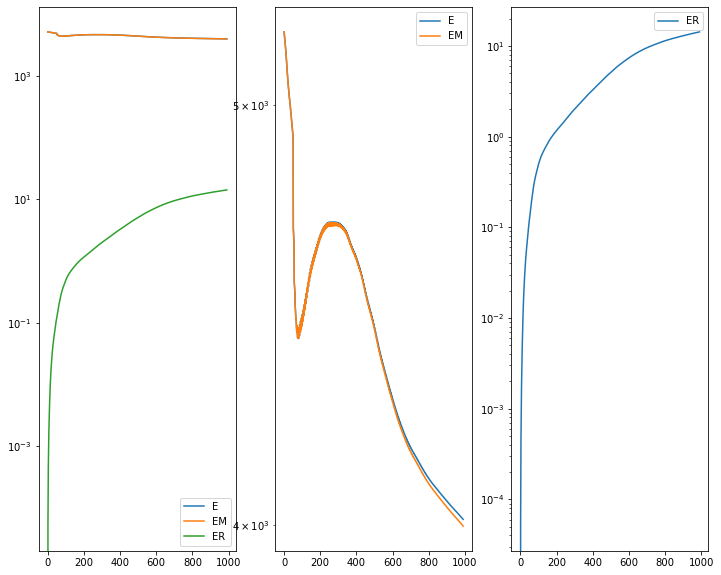

In [49]:
# run LDDMM
# running this on my desktop so cpu device
device = 'cpu' 

# keep all other parameters default
params = {
          'niter': 1000,
          'device':device,
          'sigmaM':1.5,
          'sigmaB':1.0,
          'sigmaA':1.5,
          'epV': 100,
          'muB': torch.tensor([0,0,0]), # black is background in target
          }

Ifoo = np.vstack((I, I, I)) # make RGB instead of greyscale
Jfoo = np.vstack((J, J, J)) # make RGB instead of greyscale
A,v,xv = STalign.LDDMM([YI,XI],Ifoo,[YJ,XJ],Jfoo,**params)

Plots generated throughout the alignment can be used to give you a sense of whether the parameter choices are appropriate and whether your alignment is converging on a solution.

We can also evaluate the resulting alignment by applying the transformation to visualize how our source and target images were deformed to achieve the alignment. 

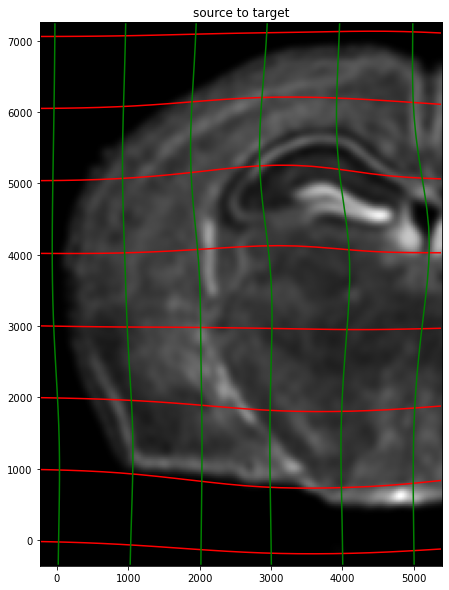

In [50]:
# apply transform
phii = STalign.build_transform(xv,v,A,XJ=[YJ,XJ],direction='b')
phiI = STalign.transform_image_atlas_to_target(xv,v,A,[YI,XI],Ifoo,[YJ,XJ])

# plot with grids
fig,ax = plt.subplots()
levels = np.arange(-100000,100000,1000)
ax.contour(XJ,YJ,phii[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XJ,YJ,phii[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('source to target')
ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent=extentJ)
ax.invert_yaxis()

Note that because of our use of LDDMM, the resulting transformation is invertible.

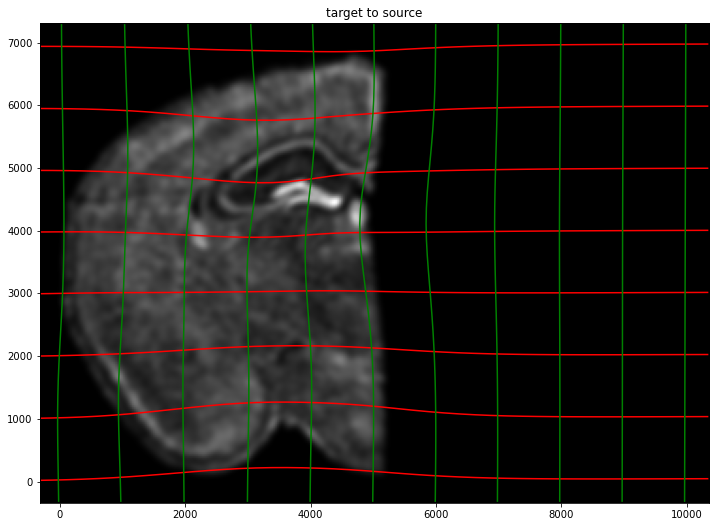

In [51]:
# transform is invertible
phi = STalign.build_transform(xv,v,A,XJ=[YI,XI],direction='f')
phiiJ = STalign.transform_image_target_to_atlas(xv,v,A,[YJ,XJ],Jfoo,[YI,XI])

# plot with grids
fig,ax = plt.subplots()
levels = np.arange(-100000,100000,1000)
ax.contour(XI,YI,phi[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XI,YI,phi[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('target to source')
ax.imshow(phiiJ.permute(1,2,0)/torch.max(phiiJ),extent=extentI)
ax.invert_yaxis()

Finally, we can apply our transform to the original sets of single cell centroid positions to achieve their new aligned positions.

In [52]:
# apply transform to original points
tpointsJ = STalign.transform_points_target_to_atlas(xv,v,A, np.stack([yJ, xJ], 1))

# just original points for visualizing later
tpointsI = np.stack([xI, yI]) 

And we can visualize the results.

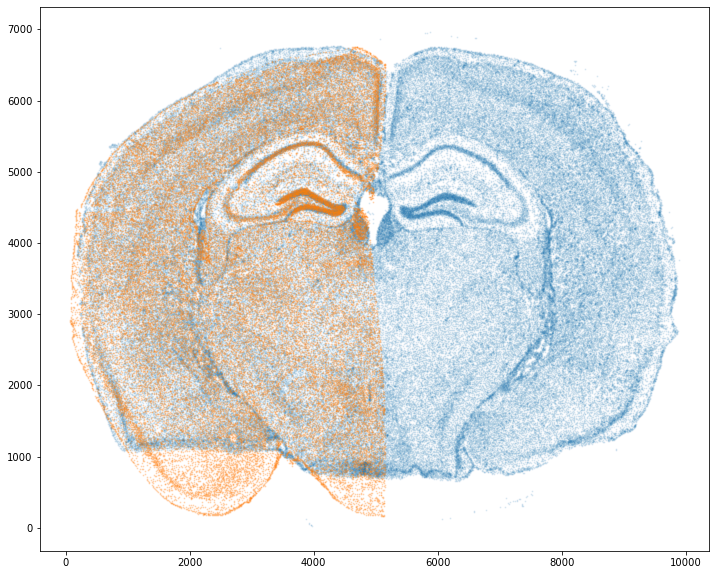

In [53]:
# plot results
fig,ax = plt.subplots()
ax.scatter(tpointsI[0,:],tpointsI[1,:],s=1,alpha=0.1) 
ax.scatter(tpointsJ[:,1],tpointsJ[:,0],s=1,alpha=0.2) # also needs to plot as y,x not x,y